#### Copyright 2018 Google LLC.


In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visualizing objective functions by interpolating in randomly drawn directions


**Motivation**

Useful visualizations of high dimensional objective functions are challenging and often require projecting to a low dimension.


**Contribution**

We introduce a new technique for visualizing the local objective function that provides information about the gradient, curvature, and flatness by estimating the objective function at pertubations around a selected point. 

In [2]:
#@title Import Statements
%pylab inline
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import seaborn as sns
import scipy
tf.enable_eager_execution(config=tf.ConfigProto(log_device_placement=True))
tf.logging.set_verbosity(tf.logging.DEBUG)
tfe = tf.contrib.eager
sns.set_context('notebook', font_scale=1.25)
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


## Background

We are interested in the problem of searching for a set of parameters $x^*\in\mathbb{R}^n$ that minimize the loss function $L(x)\in\mathbb{R}$: $x^* = \arg\min_x L(x)$. In the case where $L(x)$ is convex, a well tuned algorithm like gradient descent will converge to a global optimum. In the case where $L(x)$ is non-convex there might be many critical points: local optima, plateaus, saddle points. We can use the Hessian, $H$, distinguish between these critical points.  However, if the loss function is high dimensional, computing the Hessian is not computationally efficient.

Existing techniques (Goodfellow et al 2015) visualize one or two dimensional slices of the objective by interpolating between selected points. However, these techniques are limited to a few-dimensions and conclusions that are made from them can be limiting (Draxler et al 2018). Here we describe a new analysis technique for visualizing the landscape.


## Method 
In this section, we briefly describe the proposed technique. To understand how $L(x)$ changes around $x_0$, our method proceeds by repeatedly drawing vectors $d_i=\frac{d_i'}{||d_i'||}\in\mathbb{R^n}$ where $d_i'\sim N(0, I)$. We then evaluate $L_{+\alpha}=L(x + \alpha d_i)$ to understand how the loss function would change if we made a step in that direction: If we were at a local minima, all directions, $d_i$, would result in the loss increasing. If most directions resulted in a positive change and some negative, we might be close to a local optima or at a saddle point. To disambiguate these two situations, we also evaluate $L_{-\alpha}=L(x_0 - \alpha d_i)$. By evaluating the centered pair of data points: $(L(x_0) - L_{+\alpha}, L(x_0) - L_{-\alpha})$ we can distinguish the following cases:


1.   All pairs have both members negative implies $x_0$ is a local optimum
2.   All pairs have one positive and one negative member implies $x_0$ might be in a linear region.
3.   Some pairs have either both members positive or both members negative implies $x_0$ is a saddle point.

In additon, if the changes were close to zero then we could be in a flat region.

## Visualizing toy loss functions

We claim that our method provides insightful visualizations of functions with complicated geometry. For example, local minima, saddle points and plateaus. To demonstrate the utilitiy of the method in distinguishing the situations shown in Method we use the function $L(x)=(1-x_1 x_2)^2$ where $x=(x_1, x_2)$ as in Goodfellow et al. 2015.


In [0]:
def L_goodfellow_saddle(x):
  """Function given in Goodfellow et al. Accepts a np.array of dim 2."""
  return (1-x[0]*x[1]) ** 2

This function has a saddle point at $(0,0)$ and a range of local optima along $x_1 = \frac{1}{x_2}$ as shown in the following figure.


In [0]:
#@title Run this cell to initialize the library of tools being used in this notebook.
def plot_contours(
    L_fn,
    ylims=(-2., 2.),
    xlims=(-2., 2.),
    nx=10,
    ny=10,
    ax=None,
    show_contour_lines=False,
    **plot_kwargs):
  """Plots the contours of the function in 2D space.
  Args:
    L_fn: The loss function that accepts a np.ndarray of dim 2. 
    ylims: A tuple of floats containing the limits on the y-axis.
    xlims: A tuple of floats containing the limits on the x-axis.
    nx: The integer number of points from the x-domain.
    ny: The integer number of points from the y-domain.
    ax: A matplotlib.axes instance to do plots on.
    **plot_kwargs: Other arguments that will be passed onto the plotter.

  Returns:
    ax: A matplotlib.axes instance with the figure plotted.
    J: A np.ndarray of shape (nx*ny, ) with evaluations of the function.
    xy_vectors: A np.ndarray of shape (nx*ny, 2) of the evaluated points.
  """
  if ax is None: ax = plt.figure().add_subplot(111)
  # Get points to evaluat the function at.
  x = np.linspace(*xlims, num=nx)
  y = np.linspace(*ylims, num=ny)
  X, Y = np.meshgrid(x, y) # Mesh grid for combinations.
  xy_vectors = np.stack([X, Y], axis=2).reshape(-1, 2) # Reshape into a batch.
  # Batch apply the function:
  J = np.apply_along_axis(L_fn, 1, xy_vectors).reshape(nx, ny)
  cs = ax.contourf(x, y, J, **plot_kwargs) # Plot!
  if show_contour_lines: ax.contour(cs, colors='gray')
  if show_contour_lines: ax.clabel(cs, inline=True, fontsize=10, colors='gray')
  return ax, J, xy_vectors

# TODO(zaf): See if there are tools built into tensorflow that does this.
def get_flat_params(parameters):
  """Returns flattened model parameters.

  Given a list of tensorflow variables, this returns a numpy array
  containing a flat representation of all the parameters.
  Only works in eager mode.
  Args:
    parameters: The iterable containing the tf.Variable objects.
  Returns:
    A numpy array containing the parameters.
  """
  params = []
  for param in parameters:
    params.append(param.numpy().reshape(-1))
  return np.concatenate(params)


def set_flat_params(model, flat_params, trainable_only=True):
  """Set model parameters with a linear numpy array.

  Takes a flat tensor containing parameters and sets the model with
  those parameters.
  Args:
    model: The tf.keras.Model object to set the params of.
    flat_params: The flattened contiguous 1D numpy array containing
      the parameters to set.
    trainable_only: Set only the trainable parameters.
  Returns:
    The keras model from `model` but with the parameters set to `flat_params`.
  """
  idx = 0
  if trainable_only:
    variables = model.trainable_variables
  else:
    variables = model.variables

  for param in variables:
    # This will be 1 if param.shape is empty, corresponding to a single value.
    flat_size = int(np.prod(list(param.shape)))
    flat_param_to_assign = flat_params[idx:idx + flat_size]
    # Explicit check here because of: b/112443506
    if len(param.shape):  # pylint: disable=g-explicit-length-test
      flat_param_to_assign = flat_param_to_assign.reshape(*param.shape)
    else:
      flat_param_to_assign = flat_param_to_assign[0]
    param.assign(flat_param_to_assign)
    idx += flat_size
  return model

X_LABEL = r'$L(x_0+\alpha d)-L(x_0)$'
Y_LABEL = r'$L(x_0-\alpha d)-L(x_0)$'

Text(0.5,1,'Local Optimas')

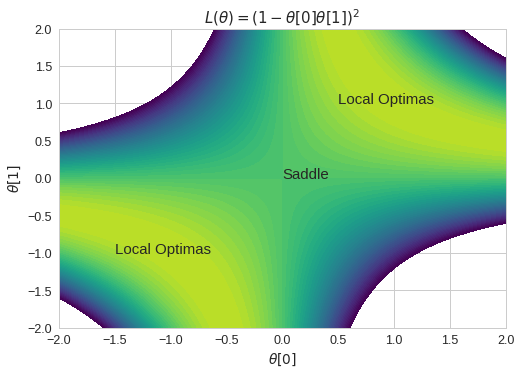

In [5]:
# plt.figure(figsize=(5, 4))
# ax = plt.gca()
ax, _, _ = plot_contours(
    L_goodfellow_saddle, nx=100, ny=100, cmap='viridis_r',
    ylims=(-2, 2), xlims=(-2, 2),
    levels=np.arange(-0.5, 5.0, 0.1).tolist(), ax=None)
ax.set_xlabel(r'$\theta[0]$')
ax.set_ylabel(r'$\theta[1]$')
ax.set_title(r'$L(\theta) = (1-\theta[0]\theta[1])^2$')
# plt.xlim(-2.5, 2.5)
# plt.ylim(-2.5, 2.5)
# plt.plot(x0, x1, linestyle='--', color='k')
plt.text(0, 0, 'Saddle', )
optima_manifold = np.linspace(-2, 2)
# ax.scatter(list(zip(optima_manifold, 1/optima_manifold)))
plt.text(-1.5, -1, 'Local Optimas')
plt.text(0.5, 1, 'Local Optimas')

### A first step: linear interpolations

We first look at an example where we contrast linear interpolation with the proposed technique.

In [0]:
x0 = np.array([-2, -0.5])
x1 = np.array([-0.5, -2.])

In [0]:
alphas = np.linspace(-0.5, 1.5, num=50)
L_vals = []
for alpha in alphas:
  new_x = (1-alpha)*x0 + alpha*x1
  L_vals.append(-L_goodfellow_saddle(new_x))

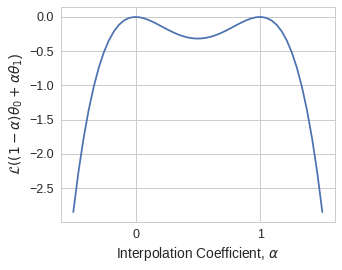

In [8]:
plt.figure(figsize=(5, 4))
plt.plot(alphas, L_vals)
plt.xlabel(r'Interpolation Coefficient, $\alpha$')
plt.ylabel(r'$\mathcal{L}((1-\alpha)\theta_0+\alpha\theta_1$)')
plt.xticks([0.0, 1.0])
plt.tight_layout()
# plt.savefig('demo_interpolation.pdf')

A Linear interpolation would be correct in pointing us to the fact that there is a local optima, but would mislead us into thinking that there was no path from the left optima to the right optima. In fact, if we plot the loss function, we see that this slice actually goes through a region of high loss before making it into another region with a local optima.

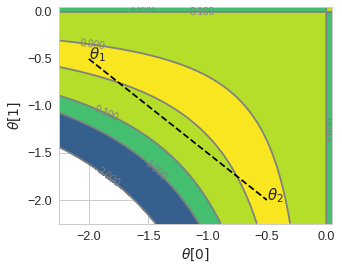

In [9]:
plt.figure(figsize=(5, 4))
ax = plt.gca()
ax, _, _ = plot_contours(
    L_goodfellow_saddle, nx=100, ny=100, cmap='viridis_r',
    ylims=(-2.25, 0.05), xlims=(-2.25, 0.05),
    show_contour_lines=True,
    levels=[0.0, 0.1, 1.0, 2.0, 5.0], ax=ax)
ax.set_xlabel(r'$\theta[0]$')
ax.set_ylabel(r'$\theta[1]$')


plt.xlim(-2.25, 0.05)
plt.ylim(-2.25, 0.05)
plt.plot(x0, x1, linestyle='--', color='k')
plt.text(x0[0], x0[1], r'$\theta_1$')
plt.text(x1[0], x1[1], r'$\theta_2$')
plt.tight_layout()

# plt.savefig('demo_curve.pdf')

### Proposed Approach

In [0]:

def sample_directions(x_dim, num_samples=100):
  """Sample normalized random directions.

  Args:
    L_fn: A function that accepts a np.ndarray and returns the loss
      as a float at that point.
    x0: A np.ndarray representing the point around which to sample.
    norm: The maximum norm of the movement direction.
    num_samples: The number of samples to obtain.

  Returns:
    A np.ndarray of shape (num_samples, x_dim) such that the L2 norms are 1
    along the x_dim.
  """
  random_directions = np.random.normal(size=(num_samples, x_dim))
  random_directions /= np.linalg.norm(random_directions, axis=1).reshape(-1, 1)
  return random_directions

def get_purturbed_directions(x0, step_size=1.0, num_samples=100):
  """Get perturbed parameters.

  Args:
    x0: A np.ndarray representing the central parameter to perturb.
    step_size: A float representing the size of the step to move in.
    num_samples: The integer number of samples to draw.

  Returns:
    Two np.ndarrays representing x0 perturbed by adding a random direction and
    minusing it. They are paired so that they move by the same direction at each
    index.
  """
  directions = sample_directions(x0.shape[0], num_samples)
  forward_step_points = x0.reshape(1, -1) +  step_size * directions
  backward_step_points = x0.reshape(1, -1) -  step_size * directions
  return forward_step_points, backward_step_points

def get_sampled_loss_function(
  L_fn, x0, step_size=1.0, num_samples=100, x0_samples=1, return_points=False):
  """Sample the loss function around the perturbations.

  Args:
    L_fn: A callable function that takes a np.ndarray representing parameters
      and returns the loss.
    x0: A np.ndarray representing the central parameter to perturb.
    step_size: A float representing the size of the step to move in.
    num_samples: The integer number of samples to draw.
    x0_samples: The integer number of times to sample x0 (default is 1). Set > 1
      if the loss function is stochastic.
  """
  forward_step_points, backward_step_points = get_purturbed_directions(
    x0, step_size, num_samples)
  if x0_samples == 1:
    L_eval = L_fn(x0)
  else: 
    L_eval = np.mean([L_fn(x0) for _ in range(x0_samples)])
  L_forward_eval = np.apply_along_axis(L_fn, 1, forward_step_points) - L_eval
  L_backward_eval = np.apply_along_axis(L_fn, 1, backward_step_points) - L_eval
  if return_points:
    return (
        L_forward_eval,
        L_backward_eval,
        forward_step_points,
        backward_step_points)
  else:
    return L_forward_eval, L_backward_eval

We now show the scatter plots from our proposed technique. 

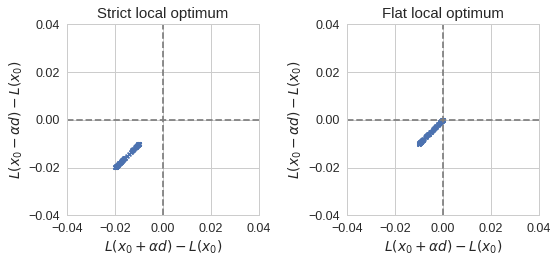

In [11]:
#######
## Define some simple loss functions for exposition.
#######

def L_quad(x):
  """Purely quadratic function."""
  return - x[0]**2 - 2.*x[1]**2

def L_flat_quad(x):
  """A quadratic function with one direction weighted with 0."""
  return -x[0]**2 - 0.*x[1]**2

def L_saddle(x):
  """A function with a saddle point"""
  return -2*x[0]**2 + 2*x[1]**2

def L_linear(x):
  """A linear function."""
  return -2*x[0] + 2*x[1]


plt.figure(figsize=(8, 5))
plt.subplot(121)
forward_samples, backward_samples = get_sampled_loss_function(
    L_quad, np.array([0.0, 0.0]), step_size=0.1)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.gca().set_aspect('equal')
plt.title(r'Strict local optimum')
plt.gca().set_xlim(-0.04, 0.04)
plt.gca().set_ylim(-0.04, 0.04)

plt.subplot(122)
forward_samples, backward_samples = get_sampled_loss_function(
    L_flat_quad, np.array([0.0, 0.0]), step_size=0.1)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.gca().set_aspect('equal')
plt.title(r'Flat local optimum')
plt.gca().set_xlim(-0.04, 0.04)
plt.gca().set_ylim(-0.04, 0.04)

plt.tight_layout()
# plt.savefig('LM_scatter_comparisons.pdf')


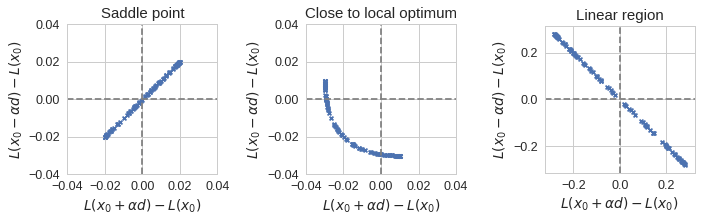

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(131)
forward_samples, backward_samples = get_sampled_loss_function(
    L_saddle, np.array([0.0, 0.0]), step_size=0.1)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.gca().set_aspect('equal')
plt.title(r'Saddle point')
plt.gca().set_xlim(-0.04, 0.04)
plt.gca().set_ylim(-0.04, 0.04)


plt.subplot(132)
forward_samples, backward_samples = get_sampled_loss_function(
    L_quad, np.array([0.1, 0.0]), step_size=0.1)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.gca().set_aspect('equal')
plt.title(r'Close to local optimum')
plt.gca().set_xlim(-0.04, 0.04)
plt.gca().set_ylim(-0.04, 0.04)

plt.subplot(133)
forward_samples, backward_samples = get_sampled_loss_function(
    L_linear, np.array([0.1, 0.0]), step_size=0.1)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.gca().set_aspect('equal')
plt.title(r'Linear region')
# plt.gca().set_xlim(-0.04, 0.04)
# plt.gca().set_ylim(-0.04, 0.04)

plt.tight_layout()
plt.savefig('linear_scatter_comparisons.pdf')


We now visualize the point given from the first section. 

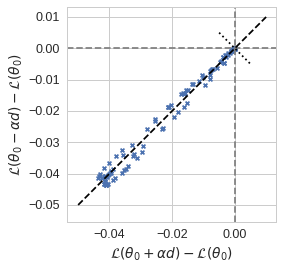

In [0]:
plt.figure(figsize=(5, 4))
# plt.subplot(121)
forward_samples, backward_samples = get_sampled_loss_function(L_goodfellow_saddle, np.array([-0.5, -2.]), step_size=0.1)
plt.scatter(-forward_samples, -backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.plot(np.linspace(-0.05, 0.01), np.linspace(-0.05, 0.01), linestyle='--', color='k')
plt.plot(np.linspace(-0.005, 0.005), -np.linspace(-0.005, 0.005), linestyle=':', color='k')
plt.xlabel(r'$\mathcal{L}(\theta_0+\alpha d)-\mathcal{L}(\theta_0)$')
plt.ylabel(r'$\mathcal{L}(\theta_0-\alpha d)-\mathcal{L}(\theta_0)$')
plt.gca().set_aspect('equal')
plt.tight_layout()
# plt.title(r'$x_0=(-0.5, -2)$: Minima')
# plt.savefig('demo_scatter2.pdf')

Our technique correctly recovers that this point is a flat local optimum.

In [0]:
# files.download('linear_scatter_comparisons.pdf')
# files.download('LM_scatter_comparisons.pdf')

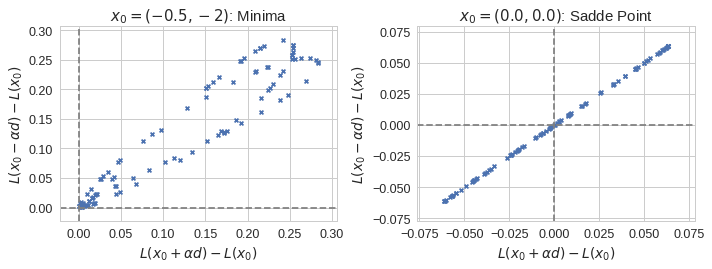

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
forward_samples, backward_samples = get_sampled_loss_function(L_goodfellow_saddle, np.array([-0.5, -2.]), step_size=0.25)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.title(r'$x_0=(-0.5, -2)$: Minima')
plt.subplot(122)
forward_samples, backward_samples = get_sampled_loss_function(L_goodfellow_saddle, np.array([0., 0.]), step_size=0.25)
plt.scatter(forward_samples, backward_samples,  s=15, marker='x')
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.title(r'$x_0=(0.0, 0.0)$: Sadde Point')
plt.tight_layout()

These help us distinguish between optima which have flat regions around them as well as saddle points. Note that the flatness is defined because of the points around 0. We contrast this with a quadratic function with one local minima has no points around zero:


### Obtaining gradient and curvature information from visualizations

We claim that this method can provide information regarding gradient and curvature of the local loss function. Let us assume that our loss function is locally quadratic: $L(x) = a^T x + \frac{1}{2}x^THx$. We have that:
$$\frac{1}{2}(L(x_0 + \alpha d) - L(x_0 -\alpha d))=\alpha a^Td$$ 
and
$$\frac{1}{2}(L(x_0 + \alpha d) + L(x_0 -\alpha d))=\alpha^2d^THd$$
which correspond to projecting $(L(x_0+\alpha d), L(x_0-\alpha d))$ on the $x=-y$ and $x=y$ axes respectively. Therefore, projections of our scatter plots  capture information about the components of the gradient and Hessian in the random direction $d$. By repeatedly sampling many directions we eventually recover how the gradient and curvature vary in many directions around $x_0$. We can use a histogram to describe the density of these curvatures In particular, the maximum and minimum curvature values obtained from this technique are close to the maximum and minimum eigenvalues of $H$. This curvature spectrum is related to eigenvalue spectra which have been used before to analyze neural networks





In [0]:
# These axes recover the gradient and curvature spectrum when projecting the 2D
# scatter plot evaluations.
CURVATURE_AX = np.array([1, 1])  # x = y
GRADIENT_AX = np.array([1, -1])  # x = -y

def scalar_project(x, v):
  """Calculate the scalar projection of vector x onto vector v."""
  v_hat = v / np.linalg.norm(v)
  return np.dot(v_hat, x)


def get_gradient_projection(values_centered):
  """Project 2D points onto the x=-y axis which gives gradient information."""
  return np.apply_along_axis(
      lambda x: scalar_project(x, GRADIENT_AX), 1, values_centered)


def get_curvature_projection(values_centered):
  """Project 2D points onto the x=y axis which gives curvature information."""
  return np.apply_along_axis(
      lambda x: scalar_project(x, CURVATURE_AX), 1, values_centered)



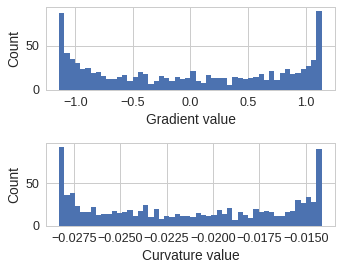

In [0]:
plt.figure(figsize=(5, 4))
plt.subplot(211)
forward_samples, backward_samples = get_sampled_loss_function(
    L_basic, np.array([-0.5, -2.]), step_size=0.1,num_samples=1000)
projections = get_gradient_projection(np.array([forward_samples, backward_samples]).T)

plt.hist(projections, bins=50)
plt.xlabel('Gradient value')
plt.ylabel('Count')
plt.subplot(212)
projections = get_curvature_projection(np.array([forward_samples, backward_samples]).T)
plt.hist(projections, bins=50)
plt.xlabel('Curvature value')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('demo_spectra_joined.pdf')

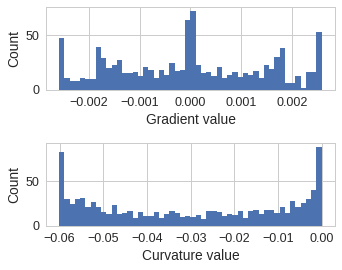

In [0]:
plt.figure(figsize=(5, 4))
plt.subplot(211)
forward_samples, backward_samples = get_sampled_loss_function(
    L_goodfellow_saddle, np.array([-0.5, -2.]), step_size=0.1,num_samples=1000)
projections = get_gradient_projection(np.array([forward_samples, backward_samples]).T)

plt.hist(projections, bins=50)
plt.xlabel('Gradient value')
plt.ylabel('Count')
plt.subplot(212)
projections = get_curvature_projection(np.array([forward_samples, backward_samples]).T)
plt.hist(projections, bins=50)
plt.xlabel('Curvature value')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('demo_spectra_joined.pdf')


### Visualizing Objective Functions for Fashion MNIST

We demonstrate the utility of our technique for visualizing the loss function for neural networks. We first visualize the loss function for a single layer neural network, better known as logistic regression. Since there are no non-linearitites in this scenario, the categorical cross entropy loss is convex. We sanity check our technique by visualizing the loss around the initializer and a minimizer found by optimizing using large batch stochastic gradient descent. We evaluate the loss using the whole dataset.

#### Negative Log Likelihood and Logistic Regression

In [0]:
#@title Load Fashion MNIST.

(X_train, Y_train), _ = tf.keras.datasets.fashion_mnist.load_data()

dataset_size = len(X_train)
output_size = 10

# Convert the array to float32 and normalize by 255
# Add a dim to represent the RGB index for CNNs
X_train = np.expand_dims((X_train.astype(np.float32) / 255.0), -1)
image_size = X_train.shape[1:]

Y_train = tf.keras.utils.to_categorical(Y_train, output_size).astype(np.float32)


4423680/4422102 [==============================] - 0s 0us/step


In [0]:
#@title Create a simple Network.

with tf.device('gpu:0'):
  model = tf.keras.Sequential(
    [
      tf.keras.layers.Flatten(input_shape=image_size),
      tf.keras.layers.Dense(output_size, activation=tf.nn.softmax)
    ]
  )

  learning_rate = tf.Variable(0.1, trainable=False)
  
  
  optimizer = tf.train.MomentumOptimizer(
      learning_rate=learning_rate,
      momentum=0.9)
  
  
  get_decayed_learning_rate = tf.train.polynomial_decay(
    learning_rate,
    tf.train.get_or_create_global_step(),
    5000000,
    learning_rate.numpy() * 0.001)
  
#   model.call = tfe.defun(model.call)
  # We will now compile and print out a summary of our model
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  model.summary()
  model_copy = tf.keras.models.clone_model(model)
  
  model_copy.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])

  def L_fn_mnist(weights):
    # Closure that allows us to get information about the loss function.
    set_flat_params(model_copy, weights)
    loss, _ = model_copy.evaluate(
        full_dataset.make_one_shot_iterator(),
        steps=1,
        verbose=0)
    return loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.get_weights()

[array([[ 0.00901222, -0.01924451,  0.02490631, ...,  0.00733211,
         -0.02085643,  0.01626516],
        [-0.00704636, -0.00503522,  0.03562833, ..., -0.03469987,
         -0.04699713, -0.01098502],
        [ 0.0682435 , -0.06097606,  0.04246155, ..., -0.00540315,
          0.07258769,  0.076338  ],
        ...,
        [ 0.00417004,  0.07394544, -0.05123962, ..., -0.0273262 ,
          0.05549467, -0.02106749],
        [ 0.08291418,  0.08620117, -0.08238684, ...,  0.05222889,
         -0.08504245,  0.05374814],
        [ 0.01298025, -0.06220732, -0.05558827, ..., -0.04268931,
         -0.04723215,  0.08244202]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

Around the initializer, the loss function is linear.

total time: 0.04557442665100098


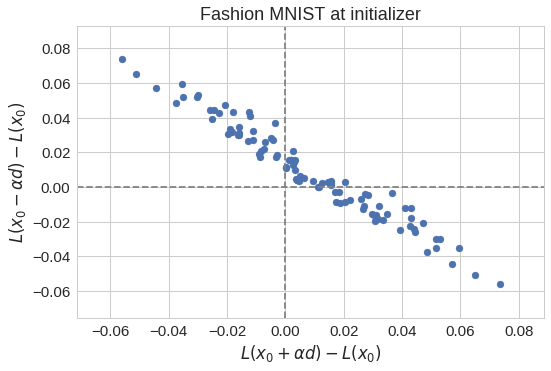

In [0]:
# Save the initializer.
initializer_weights = get_flat_params(model.variables)
start = time.time()
forward_samples, backward_samples = get_sampled_loss_function(
    L_fn_mnist,
    initializer_weights,
    step_size=1.0,
    num_samples=200,
    x0_samples=10)

# Free Doubling of points..
plt.scatter(
  np.concatenate([forward_samples, backward_samples]),
  np.concatenate([backward_samples, forward_samples]), s=2, marker='x')

print('total time: {}'.format(time.time() - start))
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.title(r'Fashion MNIST at initializer')
plt.tight_layout()

In [0]:
"""
Create some callbacks to allow us to print learning rate and other things.
"""
tf.train.get_or_create_global_step().assign(0)
BATCH_SIZE=60000
FULL_DATASET_SIZE = X_train.shape[0]
# Create the dataset
original_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset = original_dataset.batch(BATCH_SIZE)

dataset = dataset.prefetch(1)
dataset = dataset.repeat()

full_dataset = original_dataset.batch(FULL_DATASET_SIZE)

def lr_decay_callback(*args):
  learning_rate.assign(get_decayed_learning_rate())
  tf.train.get_or_create_global_step().assign_add(1)

def lr_print_callback(epoch, logs):
  step = tf.train.get_or_create_global_step().numpy()
  if step % 50 == 0 or step == 0:
    print(
        'Step {}, Learning rate: {}, Metrics: {}'.format(
            step, learning_rate.numpy(),logs))

learning_rate_decay_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lr_decay_callback)
learning_rate_print_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lr_print_callback)

callbacks = [learning_rate_decay_callback, learning_rate_print_callback]


In [0]:
# Train!

EPOCHS=15000

history = model.fit(
  dataset, epochs=EPOCHS, steps_per_epoch=FULL_DATASET_SIZE // BATCH_SIZE,
  callbacks=callbacks, verbose=0)
 

_footnote: We note that this final accuracy comes close the results of a multi-layer neural network (and better than logistic regression) to those published on the Authors benchmarking website._

In [0]:
np.save('weights.npy', model.get_weights())
from google.colab import files
files.download('weights.npy')  # NTS: save to google drive for week Oct 22
final_weights = get_flat_params(model.variables)
np.save('final_weights_flat.npy', final_weights)
files.download('final_weights_flat.npy')  # NTS: save to google drive for week Oct 22

total time: 127.49810600280762


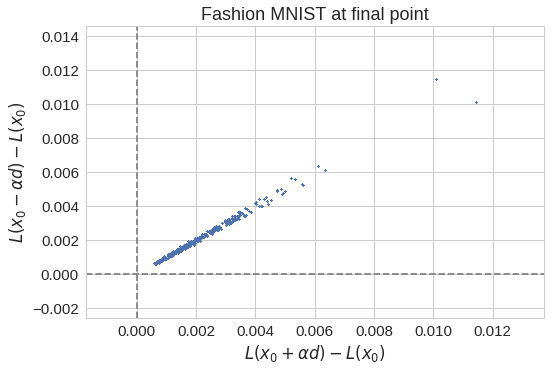

In [0]:
start = time.time()
forward_samples, backward_samples = get_sampled_loss_function(
  L_fn_mnist, final_weights, step_size=1.0, num_samples=200, x0_samples=10)
# Free Doubling of points..
plt.scatter(
  np.concatenate([forward_samples, backward_samples]),
  np.concatenate([backward_samples, forward_samples]), s=2, marker='x')
print('total time: {}'.format(time.time() - start))
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.title(r'Fashion MNIST at final point')
plt.tight_layout()

total time: 0.04235363006591797


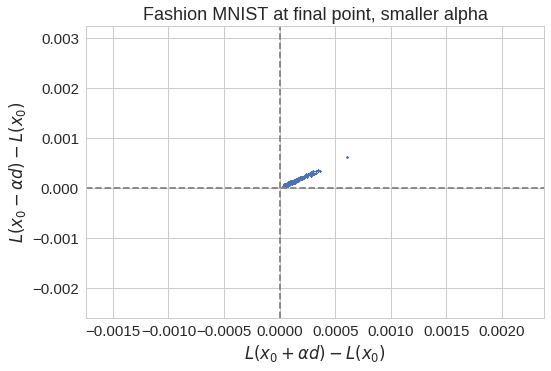

In [0]:
start = time.time()
forward_samples, backward_samples = get_sampled_loss_function(
  L_fn_mnist, final_weights, step_size=0.25, num_samples=200, x0_samples=10)
Free Doubling of points..
plt.scatter(
  np.concatenate([forward_samples, backward_samples]),
  np.concatenate([backward_samples, forward_samples]), s=2, marker='x')
print('total time: {}'.format(time.time() - start))
plt.axhline(0.0, color='gray', linestyle='--')
plt.axvline(0.0, color='gray', linestyle='--')
plt.xlabel(X_LABEL)
plt.ylabel(Y_LABEL)
plt.title(r'Fashion MNIST at final point, smaller alpha')
plt.tight_layout()

### Tracking negative curvature

In [0]:

def index_of_percentile(data, percentile, data_index=0):
  """Gets the index of the percentile in the data
  
  Args:
    data: A np.ndarray of shape (BATCH, ...)
    percentile: The percenctile of the data you want.
    data_index: An integer representing the index of `data` that you want to
      slice.
  
  Returns:
    The index closest to the percentile of the data. When accessing data[index]
    we retrieve the data at the `percentile`-th percentile. 
  """
  percentile_value = np.percentile(
    data[:, data_index],
    percentile,
    interpolation='nearest'
  )

  data_shifted = np.abs(data[:, data_index] - percentile_value)
  return np.argmin(data_shifted)

def get_curvature_of_most_improvement_direction(
  data_centered, percentile=90, data_index=0, curvature_data=None):
  """Get the curvature value for the direction which gives the most improvement.

  Args:
    data_centered: np.ndarray of containing the centered version of the data.
    percentile: An integer value of the percentile of the data.
    data_index: See `index_of_percentile`.
    curvature_data: Precomputed curvature data.

  Returns:
    Returns the curvature value that corresponds to the relative change at 
    percentile `percentile`.
  """
  
  # Get the index of the data point at the percentile'd data.
  closest_idx = index_of_percentile(data_centered, percentile, data_index)
  
  if curvature_data is None:
    # No precomputed curvature data.
    # So project the centered data and get the curvature.
    return scalar_project(
      data_centered[closest_idx, :], CURVATURE_AX)
  else:
    # Curvature data was precomputed so just returned the curvature value
    # corresponding to the index that is closest to the `percentile`th
    # percentile.
    return curvature_data[closest_idx]
